In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from common.visualization import render_animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
%matplotlib inline  

# Human3.6M Visualization

In [4]:
from short_term.dataset_h36m import dataset as h36m

if torch.cuda.is_available():
    h36m.cuda()
h36m.compute_positions() # Forward kinematics on all animations

In [5]:
h36m.subjects()

dict_keys(['S1', 'S11', 'S5', 'S6', 'S7', 'S8', 'S9'])

In [6]:
h36m['S1'].keys()

dict_keys(['directions_1_d0', 'directions_1_d1', 'directions_2_d0', 'directions_2_d1', 'discussion_1_d0', 'discussion_1_d1', 'discussion_2_d0', 'discussion_2_d1', 'eating_1_d0', 'eating_1_d1', 'eating_2_d0', 'eating_2_d1', 'greeting_1_d0', 'greeting_1_d1', 'greeting_2_d0', 'greeting_2_d1', 'phoning_1_d0', 'phoning_1_d1', 'phoning_2_d0', 'phoning_2_d1', 'posing_1_d0', 'posing_1_d1', 'posing_2_d0', 'posing_2_d1', 'purchases_1_d0', 'purchases_1_d1', 'purchases_2_d0', 'purchases_2_d1', 'sitting_1_d0', 'sitting_1_d1', 'sitting_2_d0', 'sitting_2_d1', 'sittingdown_1_d0', 'sittingdown_1_d1', 'sittingdown_2_d0', 'sittingdown_2_d1', 'smoking_1_d0', 'smoking_1_d1', 'smoking_2_d0', 'smoking_2_d1', 'takingphoto_1_d0', 'takingphoto_1_d1', 'takingphoto_2_d0', 'takingphoto_2_d1', 'waiting_1_d0', 'waiting_1_d1', 'waiting_2_d0', 'waiting_2_d1', 'walking_1_d0', 'walking_1_d1', 'walking_2_d0', 'walking_2_d1', 'walkingdog_1_d0', 'walkingdog_1_d1', 'walkingdog_2_d0', 'walkingdog_2_d1', 'walkingtogether_1_d0

The *_d0* or *_d1* suffix represents the version of the sequence after downsampling (even/odd).

In [7]:
# You can visualize the data as inline HTML5 video
#HTML(render_animation(h36m['S1']['walking_1_d0']['positions_world'][:150], h36m.skeleton(), h36m.fps(), output='html'))

<IPython.core.display.Javascript object>


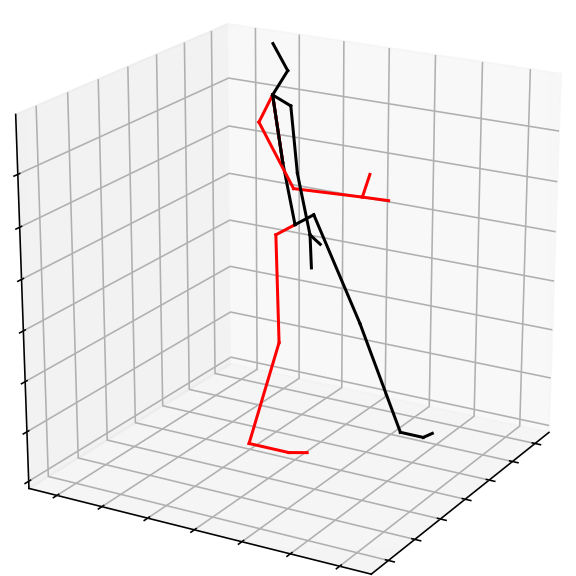

In [8]:
# Alternatively, you can visualize it interactively using the nbagg backend
%matplotlib notebook
anim = render_animation(h36m['S1']['walking_1_d0']['positions_world'][:50], h36m.skeleton(), h36m.fps(), output='interactive')

In [9]:
h36m['S1']['walking_1_d0']['positions_world'].shape

(1738, 32, 3)

In [10]:
data = h36m['S1']['takingphoto_2_d1']['positions_world'][:50]
skeleton = h36m.skeleton()

<IPython.core.display.Javascript object>


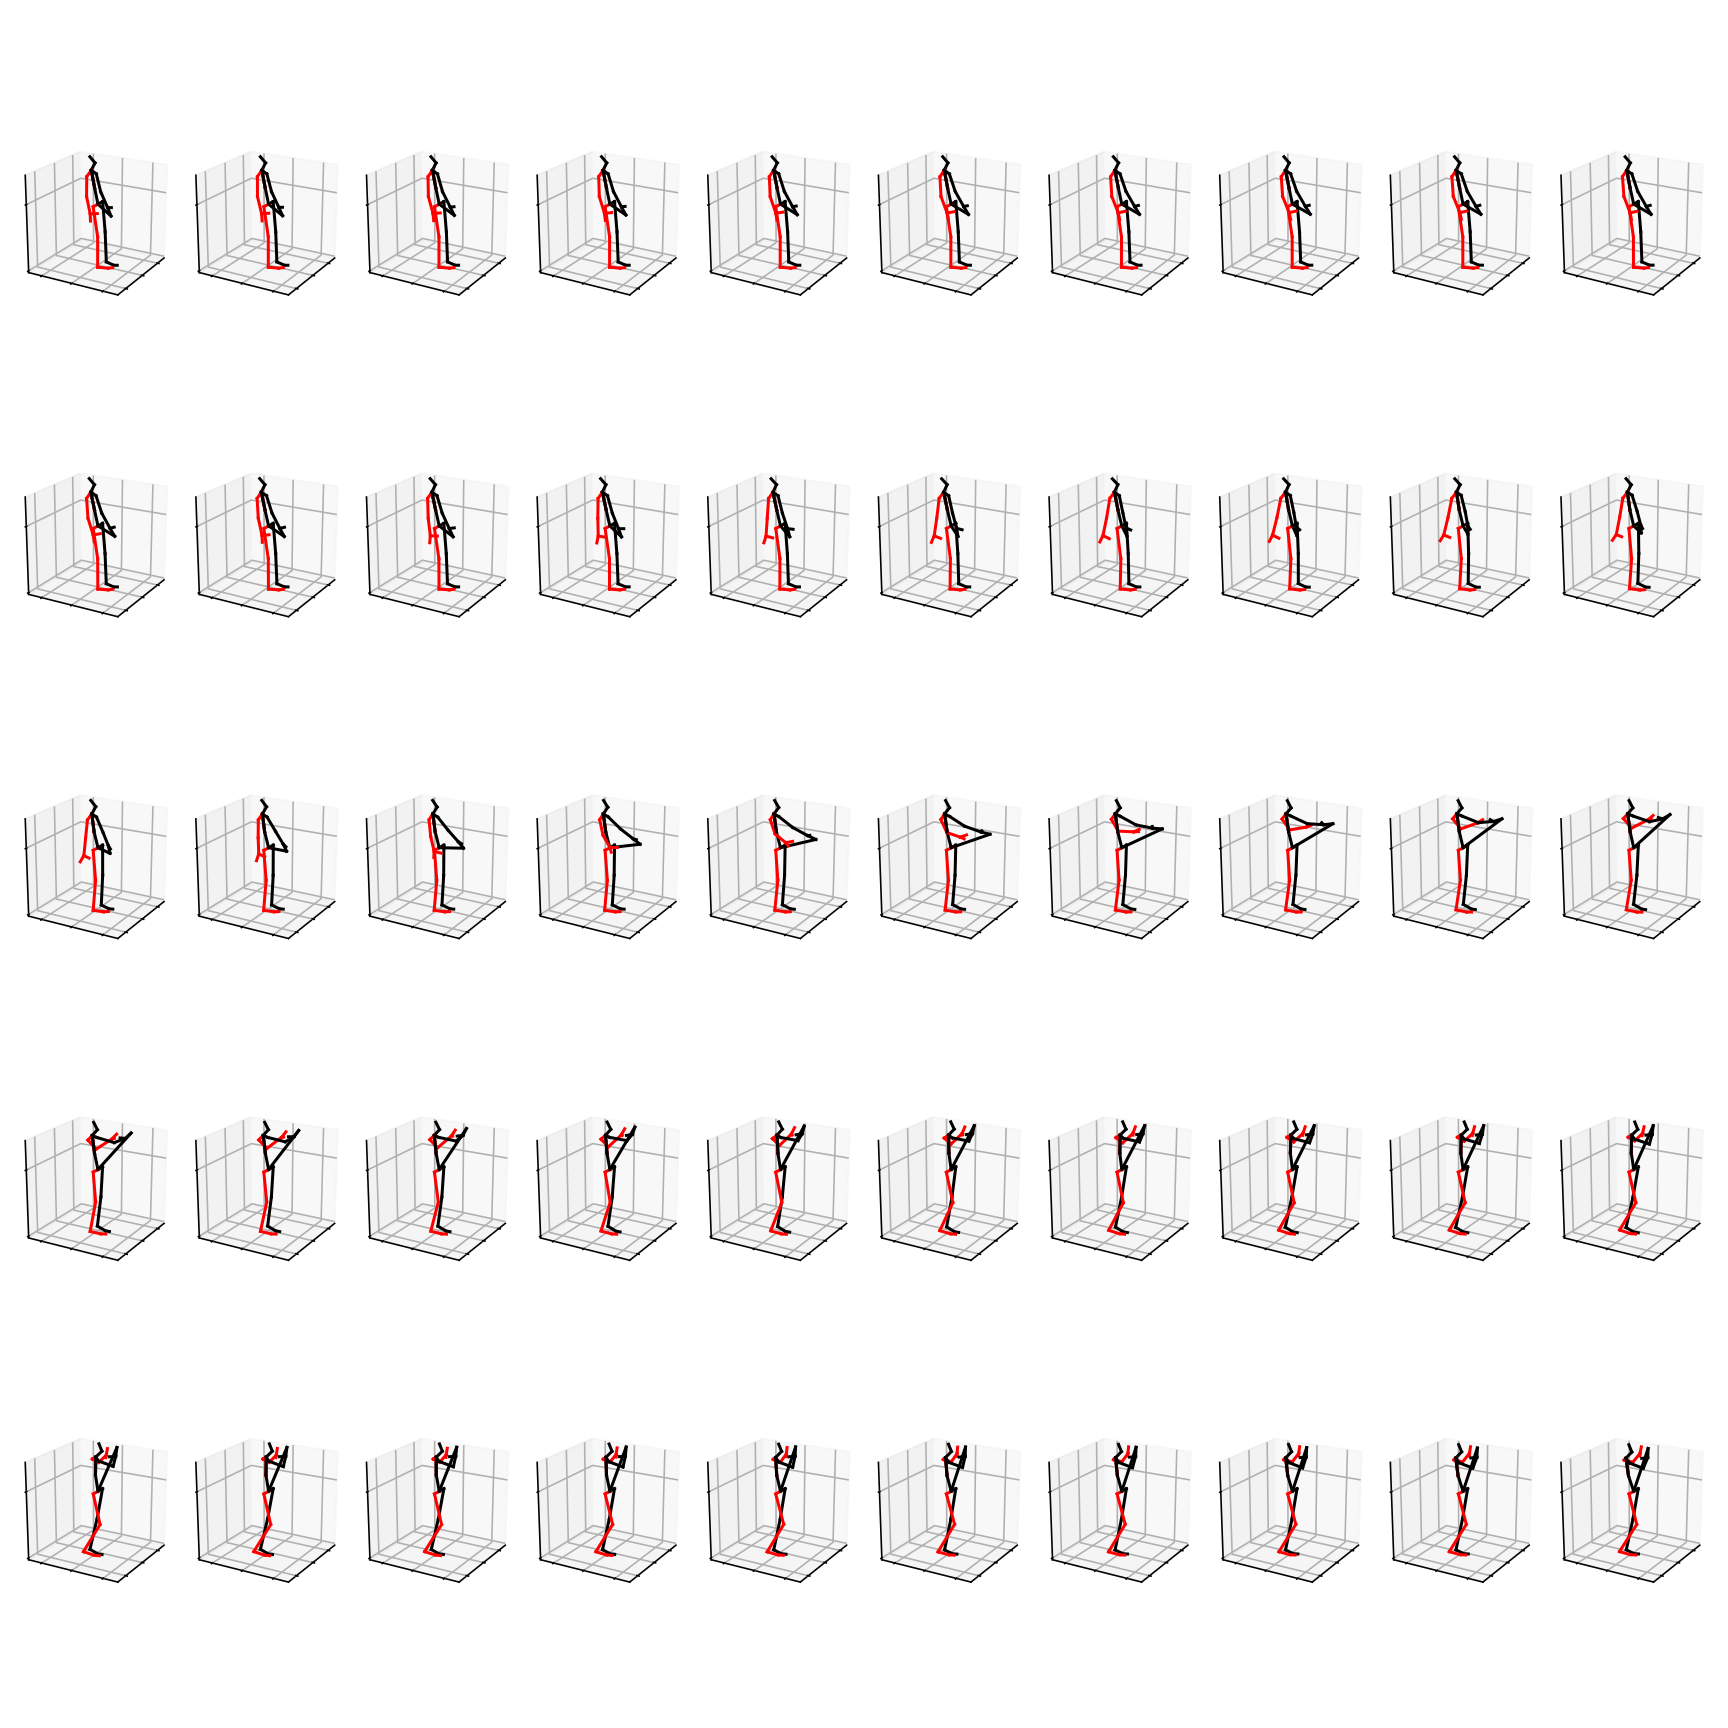

In [12]:
x = 0
y = 1
z = 2
radius = torch.max(skeleton.offsets()).item() * 5 # Heuristic that works well with many skeletons
    
skeleton_parents = skeleton.parents()

plt.ioff()
fig = plt.figure(figsize=(12, 12))
frames = np.arange(0, data.shape[0])
for frame in frames:
    frame_index = frame+1
    ax = fig.add_subplot(5, 10, frame_index, projection='3d')
    ax.view_init(elev=20., azim=30)

    ax.set_xlim3d([-radius/2, radius/2])
    ax.set_zlim3d([0, radius])
    ax.set_ylim3d([-radius/2, radius/2])
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.dist = 7.5

    lines = []

    trajectory = data[:, 0, [0, 2]]
    avg_segment_length = np.mean(np.linalg.norm(np.diff(trajectory, axis=0), axis=1)) + 1e-3
    draw_offset = int(25/avg_segment_length)
    spline_line, = ax.plot(*trajectory.T)
    camera_pos = trajectory
    height_offset = np.min(data[:, :, 1]) # Min height
    data = data.copy()
    data[:, :, 1] -= height_offset

    ax.set_xlim3d([-radius/2 + camera_pos[frame, 0], radius/2 + camera_pos[frame, 0]])
    ax.set_ylim3d([-radius/2 + camera_pos[frame, 1], radius/2 + camera_pos[frame, 1]])

    positions_world = data[frame]
    for i in range(positions_world.shape[0]):
        col = 'red' if i in skeleton.joints_right() else 'black' # As in audio cables :)
        lines.append(ax.plot([positions_world[i, x], positions_world[skeleton_parents[i], x]],
            [positions_world[i, y], positions_world[skeleton_parents[i], y]],
            [positions_world[i, z], positions_world[skeleton_parents[i], z]], zdir='y', c=col))
    l = max(frame-draw_offset, 0)
    r = min(frame+draw_offset, trajectory.shape[0])
    spline_line.set_xdata(trajectory[l:r, 0])
    spline_line.set_ydata(np.zeros_like(trajectory[l:r, 0]))
    spline_line.set_3d_properties(trajectory[l:r, 1], zdir='y')
plt.tight_layout()
#plt.savefig("plots/takingphoto.png")
plt.show()

